# Fitting interaction parameters of binary systems

Sometimes Equations of State needs an extra help to better predict behaviors.

Let's see how we can optimize binary interaction parameters (BIPs) of a Cubic
Equation, using equilibrium data.

## Data structure
For all the default approaches of parameter optimization the data points must
be in the format of a `pandas` DataFrame, with the following columns:

- `kind`: Which kind of point is defined. The options are:
    - `bubbleT`
    - `bubbleP`
    - `dewT`
    - `dewP`
    - `PT`
    - `liquid-liquid`
    - `critical`
- `T`: Temperature (in Kelvin).
- `P`: Pressure (in bar).
- `x1`: Mole fraction of component 1 (lightest component) in heavy phase. 
- `y1`: Mole fraction of component 1 (lightest component) in light phase.

Optional column:
- `weight`: A column that assign a weight factor to that data point when
    calculating the error. If not provided, all weights are assumed as 1.

Depending on the specified data point `kind` the experimental error will be
calculated differently. Moreover, different information will be needed.
"Not used" information could be set as NaN (missing data) in the dataframe

+-------------------+---------------------------------------------------------------------------+----------+
| ``kind``          | Description                                                               | Not Used |
+===================+===========================================================================+==========+
| ``bubbleT``       | A saturation temperature calculation is performed                         | ``y1``   |
|                   |                                                                           |          |
|                   | using ``P`` and  the composition ``x1``.                                  |          |
|                   |                                                                           |          |
|                   | The error is calculated between the calculated                            |          |
|                   |                                                                           |          |
|                   | saturation temperature and ``T``.                                         |          |
+-------------------+---------------------------------------------------------------------------+----------+
| ``bubbleP``       | A saturation pressure calculation is performed                            | ``y1``   |
|                   |                                                                           |          |
|                   | using ``T`` and the composition ``x1``.                                   |          |
|                   |                                                                           |          |
|                   | The error is calculated between the calculated                            |          |
|                   |                                                                           |          |
|                   | saturation pressure and ``P``.                                            |          |
+-------------------+---------------------------------------------------------------------------+----------+
| ``dewT``          | A saturation temperature calculation is                                   | ``x1``   |
|                   |                                                                           |          |
|                   | performed using ``P`` and the composition ``y1``.                         |          |
|                   |                                                                           |          |
|                   | The error is calculated between the calculated                            |          |
|                   |                                                                           |          |
|                   | saturation temperature and ``T``.                                         |          |
+-------------------+---------------------------------------------------------------------------+----------+
| ``dewP``          | A saturation pressure calculation is performed                            | ``x1``   |
|                   |                                                                           |          |
|                   | using ``T`` and the composition ``y1``.                                   |          |
|                   |                                                                           |          |
|                   | The error is calculated between the calculated                            |          |
|                   |                                                                           |          |
|                   | saturation pressure and ``P``.                                            |          |
+-------------------+---------------------------------------------------------------------------+----------+
| ``PT``            | A flash calculation is performed at ``T`` and ``P``.                      | —        |
|                   |                                                                           |          |
|                   | The error is calculated between the calculated                            |          |
|                   |                                                                           |          |
|                   | light phase composition and ``y1`` (if ``y1`` is provided)                |          |
|                   |                                                                           |          |
|                   | and between the calculated heavy phase                                    |          |
|                   |                                                                           |          |
|                   | composition and ``x1`` (if ``x1`` is provided).                           |          |
|                   |                                                                           |          |
|                   | You must provide ``x1``, ``y1`` or both.                                  |          |
+-------------------+---------------------------------------------------------------------------+----------+
| ``liquid-liquid`` | Same as ``PT`` kind but a liquid-liquid flash initialization is searched. | —        |
+-------------------+---------------------------------------------------------------------------+----------+
| ``critical``      | The critical line is calculated.                                          | ``y1``   |
|                   |                                                                           |          |
|                   | Since is a critical point both ``x1`` and ``y1`` are the same.            |          |
|                   |                                                                           |          |
|                   | The error is calculated between the calculated pressure, temperature      |          |
|                   |                                                                           |          |
|                   | and composition and ``P``, ``T`` and ``x1`` respectively.                 |          |
+-------------------+---------------------------------------------------------------------------+----------+


As shown, depending on the kind of each data point, some information is
mandatory and other is not used. This behaviour allows the user to adjust
the same data points to different kinds and enhance the fitting results.

In the following cell we import the data points from a `.csv` file

In [20]:
import pandas as pd

import numpy as np


df = pd.read_csv('./data/CO2_C6.csv')

df

,kind,T,P,x1,y1
0,bubbleP,303.15,20.24,0.2385,0.9721
1,bubbleP,303.15,30.36,0.3698,0.9768
2,bubbleP,303.15,39.55,0.5063,0.9815
3,bubbleP,303.15,50.95,0.7078,0.9842
4,bubbleP,303.15,57.83,0.8430,0.9855
5,bubbleP,303.15,64.68,0.9410,0.9884
6,bubbleP,303.15,67.46,0.9656,0.9909
7,bubbleP,315.15,20.84,0.2168,0.9560
8,bubbleP,315.15,30.40,0.3322,0.9660
9,bubbleP,315.15,40.52,0.4446,0.9748


This data set consist of multiple bubble pressure data points at two different
temperatures. Both liquid (`x1`) and vapor (`y1`) light component mole
compositions are provided.

As explained before, depending on the `kind` of data point, some columns
are not used. In this case, since we are going to use `bubbleP` kind,
the `y1` column is not used, even if it is still provided in the data set.

Since the `weight` column is not provided, all data points will be equally
weighted when calculating the error.

## Default model prediction

Before starting to fit BIPs, let's see how the model predicts without BIPs.

First, let's define the model

In [21]:
import yaeos


Tc = [304.1, 504.0]     # Critical temperature in K
Pc = [73.75, 30.12]     # Critical pressure in bar
w = [0.4, 0.299]        # Acentric factor

# Peng-Robinson (1976) model without interaction parameters
model = yaeos.PengRobinson76(Tc, Pc, w)

### Claculation of Pxy diagrams
Now that the model is defined, lets calculate Pxy diagrams for each temperature.

First, we find the unique values of temperature to iterate over them later.

In [13]:
Ts = df["T"].unique()
Ts

array([303.15, 315.15])

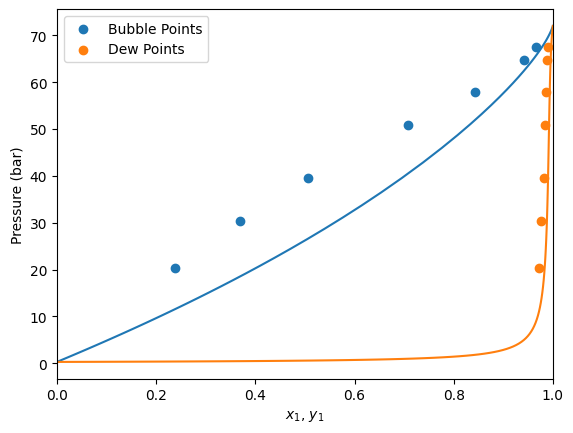

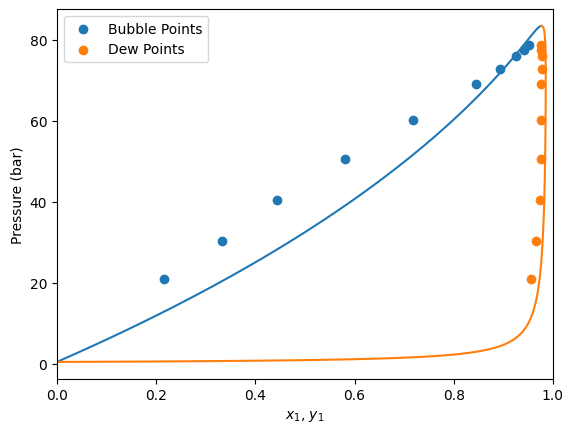

In [23]:
import matplotlib.pyplot as plt


gpec = yaeos.GPEC(model)

for T in Ts:
    msk = df["T"] == T
    pxy = gpec.plot_pxy(T)
    
    plt.scatter(df[msk]["x1"], df[msk]["P"], label="Bubble Points")
    plt.scatter(df[msk]["y1"], df[msk]["P"], label="Dew Points")
    
    plt.xlim(0, 1)
    plt.legend()
    plt.show()

Here we can see that the PengRobinson EoS present a negative deviation with
respect to the experimental points. Let's se how we can improve these
predictions.

## Definition of the optimization problem

Now that we already have our data points defined. We need to define the
optimization problem.

The `yaeos.fitting` package includes the `BinaryFitter` object, this object
encapsulates all the logic that is needed to fit binary systems.

In [15]:
import yaeos
from yaeos.fitting import BinaryFitter

?BinaryFitter

Init signature:
BinaryFitter(
    model_setter: Callable,
    model_setter_args: tuple,
    data: pandas.core.frame.DataFrame,
    verbose: bool = False,
) -> None
Docstring:     
BinaryFitter class.

This class is used to fit binary interaction parameters to experimental
data. The objective function is defined as the sum of the squared errors
between the experimental data and the model predictions.

Parameters
----------
model_setter : Callable
    A function that returns a model object. The function should take the
    optimization parameters as the first argument and any other arguments
    as the following arguments.
model_setter_args : tuple
    A tuple with the arguments to pass to the model_setter function.
data : pandas.DataFrame
    A DataFrame with the experimental data.
    The DataFrame should have the following columns:
    - kind: str, the kind of data point (bubble, dew, liquid-liquid, PT,
    critical)
    - x1: float, the mole fraction of component 1
    - y1: float, t

### Model setter function

Looking at the object's documentation we can see that we need to define a
function `model_setter` that takes the vector of fitting parameters and extra
required arguments.

In [7]:
def fit_kij(x, model):
    """Fit kij function.

    Args:
        x (list): kij value.
        model (yaeos.CubicEoS): CEOS model that will be fitted
    """
    kij = x[0]

    kij_matrix = [
        [0, kij], 
        [kij, 0]
    ]

    lij = [
        [0, 0],
        [0, 0]
    ]

    mixrule = yaeos.QMR(kij=kij_matrix, lij=lij)

    model.set_mixrule(mixrule)
    
    return model

In [8]:
problem = BinaryFitter(
    model_setter=fit_kij,
    model_setter_args=(model,),
    data=df,
    verbose=True
)

x0 = [0.0]

problem.fit(x0, bounds=None)

1.7427277515958346 [0.]
1.7367297572626244 [0.00025]
1.7307370080649485 [0.0005]
1.72474952538773 [0.00075]
1.712790445469462 [0.00125]
1.700852689778661 [0.00175]
1.6770418462495278 [0.00275]
1.6533183947480148 [0.00375]
1.6061393533646415 [0.00575]
1.559327111499111 [0.00775]
1.4668506368944916 [0.01175]
1.3759871697248645 [0.01575]
1.1995171255846175 [0.02375]
1.030807090584202 [0.03175]
0.7207125515768745 [0.04775]
0.45494890342547134 [0.06375]
0.1633296153190295 [0.09575]
0.22052696459764434 [0.12775]
0.22052696459764434 [0.12775]
0.09792206166179278 [0.11175]
0.22052696459764434 [0.12775]
0.11825669223910135 [0.10375]
0.10598288549366082 [0.11975]
0.0982342976729269 [0.11575]
0.10459879842351241 [0.10775]
0.09712360613884619 [0.11375]
0.0982342976729269 [0.11575]
0.09730049165208345 [0.11275]
0.05599850855641469 [0.11475]
0.0982342976729269 [0.11575]
0.0982342976729269 [0.11575]
0.05537507866050831 [0.11425]
0.09712360613884619 [0.11375]
0.055672585887980686 [0.1145]
0.0551058801

## Optimization result
Now that we have fitted the parameter, let's see the solution. For this, we
can see the `solution` property of the problem.
Where we can see that the optimization terminated succesfully with a `kij` value
of around `0.113`

In [9]:
problem.solution

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.054981862883314914
             x: [ 1.139e-01]
           nit: 21
          nfev: 42
 final_simplex: (array([[ 1.139e-01],
                       [ 1.139e-01]]), array([ 5.498e-02,  5.504e-02]))

### Obtain the fitted model
Now that the problem has been optimized, let's redefine our model with the
solution. For this, we use the `_get_model` method inside of the `BinaryFitter`
object. This just uses the function that we have provided originally (`fit_kij`)

In [10]:
model = problem.get_model(problem.solution.x, model)

### Make predictions
Let's repeat the calculation of Pxy diagrams that we have done earlier

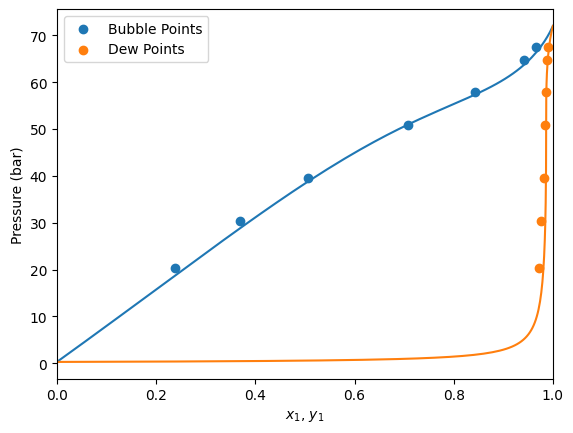

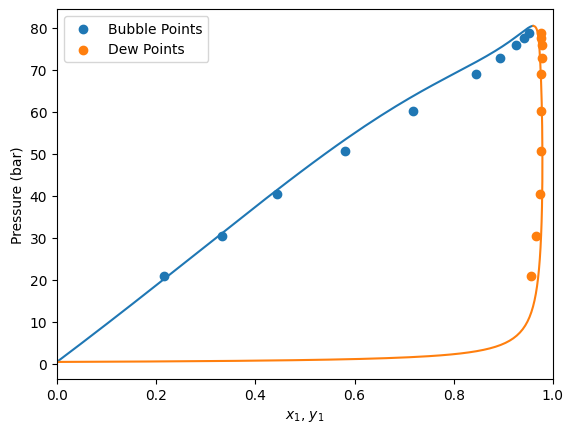

In [11]:
import matplotlib.pyplot as plt

z0 = [0, 1]
zi = [1, 0]
pxs = []
gpec = yaeos.GPEC(model)

for T in Ts:
    msk = df["T"] == T
    pxy = gpec.plot_pxy(T)
    
    plt.scatter(df[msk]["x1"], df[msk]["P"], label="Bubble Points")
    plt.scatter(df[msk]["y1"], df[msk]["P"], label="Dew Points")
    
    plt.xlim(0, 1)
    plt.legend()
    plt.show()